**Preliminaries**

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import time
from datetime import datetime

import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
from sklearn.inspection import permutation_importance

In [26]:
# set random seed to allow for scikit-learn results to reproduced
np.random.seed(22)

**Loading of Data**

In [27]:
# make a pandas DataFrame from the features extracted using Extraction.ipynb
extracted_features = pd.read_csv("https://anti-phish.s3.eu-west-1.amazonaws.com/dataset/extracted/extracted_features.csv", index_col=0)

# preview the DataFrame
extracted_features

,phishing,header-size,count-to,count-received,count-cc,count-bcc,same-id-sender,same-return-sender,subject-word-count,subject-distinct-word-count,...,body-word-count,body-distint-word-count,body-richness,body-function-word-count,has-html,has-form,difference-measure,difference-measure-unique,phishing-ratio,phishing-ratio-unique
0,0,493,1,0,0,0,True,True,13,10,...,12,12,0.352941,0,False,False,49635,47220,7.162959,7.070917
1,0,507,1,0,0,0,True,True,17,17,...,257,144,0.268828,0,True,False,180849,112657,39.625021,19.850423
2,0,3829,1,8,0,0,True,True,24,23,...,70,58,0.230263,0,True,False,341690,187225,35.636941,25.572848
3,0,1392,1,4,0,0,True,True,5,5,...,11,11,0.177419,0,False,False,77171,61707,8.020079,8.252500
4,0,1019,1,1,0,0,True,True,14,14,...,27,26,0.204545,0,True,False,56244,60999,8.682031,8.355112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14383,1,2686,1,2,0,0,True,True,10,10,...,3708,602,0.184579,3,True,False,780510,258861,169.073067,143.043212
14384,1,2823,1,2,0,0,True,True,5,5,...,739,195,0.223668,8,True,False,977919,250883,194.024057,76.146350
14385,1,2380,1,1,0,0,True,True,5,5,...,1445,202,0.208574,0,True,False,267365,144481,45.174507,33.271741
14386,1,2602,1,2,0,0,True,True,4,4,...,334,155,0.232106,1,True,False,129544,35849,13.326531,10.917989


In [28]:
# verify variable types
extracted_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14388 entries, 0 to 14387
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   phishing                     14388 non-null  int64  
 1   header-size                  14388 non-null  int64  
 2   count-to                     14388 non-null  int64  
 3   count-received               14388 non-null  int64  
 4   count-cc                     14388 non-null  int64  
 5   count-bcc                    14388 non-null  int64  
 6   same-id-sender               14388 non-null  bool   
 7   same-return-sender           14388 non-null  bool   
 8   subject-word-count           14388 non-null  int64  
 9   subject-distinct-word-count  14388 non-null  int64  
 10  subject-richness             14388 non-null  float64
 11  subject-function-word-count  14388 non-null  int64  
 12  is-reply                     14388 non-null  bool   
 13  is-forward      

In [29]:
# separate predictor and target variables
X = extracted_features.drop('phishing', axis = 1)
y = extracted_features['phishing'].values

In [30]:
# dataframe of predictor variables values
X

,header-size,count-to,count-received,count-cc,count-bcc,same-id-sender,same-return-sender,subject-word-count,subject-distinct-word-count,subject-richness,...,body-word-count,body-distint-word-count,body-richness,body-function-word-count,has-html,has-form,difference-measure,difference-measure-unique,phishing-ratio,phishing-ratio-unique
0,493,1,0,0,0,True,True,13,10,0.342105,...,12,12,0.352941,0,False,False,49635,47220,7.162959,7.070917
1,507,1,0,0,0,True,True,17,17,0.354167,...,257,144,0.268828,0,True,False,180849,112657,39.625021,19.850423
2,3829,1,8,0,0,True,True,24,23,0.252632,...,70,58,0.230263,0,True,False,341690,187225,35.636941,25.572848
3,1392,1,4,0,0,True,True,5,5,0.312500,...,11,11,0.177419,0,False,False,77171,61707,8.020079,8.252500
4,1019,1,1,0,0,True,True,14,14,0.250000,...,27,26,0.204545,0,True,False,56244,60999,8.682031,8.355112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14383,2686,1,2,0,0,True,True,10,10,0.256410,...,3708,602,0.184579,3,True,False,780510,258861,169.073067,143.043212
14384,2823,1,2,0,0,True,True,5,5,0.108696,...,739,195,0.223668,8,True,False,977919,250883,194.024057,76.146350
14385,2380,1,1,0,0,True,True,5,5,0.192308,...,1445,202,0.208574,0,True,False,267365,144481,45.174507,33.271741
14386,2602,1,2,0,0,True,True,4,4,0.160000,...,334,155,0.232106,1,True,False,129544,35849,13.326531,10.917989


In [31]:
# array of target variable phishing values
y

array([0, 0, 0, ..., 1, 1, 1])

In [32]:
from sklearn.model_selection import train_test_split

# split into 80% training and 20% testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=22)

**Model Training, Testing and Export**

**1. Naive Bayes Classificiation**

In [33]:
from sklearn.naive_bayes import GaussianNB

# parameter grid of different hyperparameters to be tuned
param_grid = [{'gaussiannb__var_smoothing': np.logspace(0,-9, num=100)}]

# pipe combining an instance of a StandardScaler() and our classification model to normalise training and testing data
pipe_nb = make_pipeline(StandardScaler(),
                        GaussianNB())
# instantiate an instance of GridSearchCV that, when fitting, will cycle through the parameter grid and choose the best classification model
model_nb = GridSearchCV(estimator=pipe_nb, param_grid=param_grid)

# track how long it takes to train the model
start_time = time.time()

# fit the Cross Validator on the training data
model_nb.fit(X_train, y_train)

nb_training_time = time.time() - start_time

# output the best chosen parameters and the model's accuracy on the testing subset
print('Model Training time:', nb_training_time, 'seconds')
print('Best parameters:', model_nb.best_params_)
print('Accuracy:', model_nb.score(X_test, y_test))

Model Training time: 9.74515175819397 seconds
Best parameters: {'gaussiannb__var_smoothing': 0.012328467394420659}
Accuracy: 0.9287699791521891


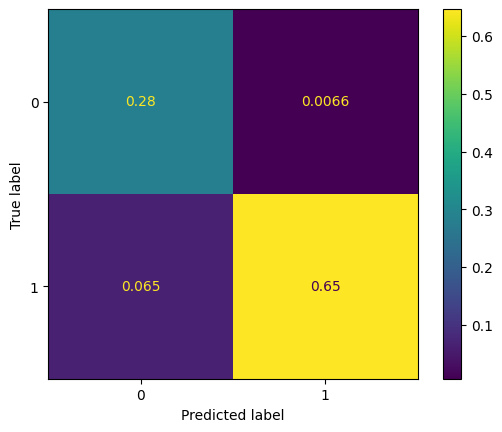

In [34]:
# calculate the predicted labels of the test set
y_pred_nb = model_nb.predict(X_test)

# generate a normalised confusion matrix comparing the predictions to the actual phishing labels
cm_nb = confusion_matrix(y_test, y_pred_nb, normalize='all')

# plot confusion matrix
ConfusionMatrixDisplay(cm_nb).plot()

In [35]:
# print classification report
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89       831
           1       0.99      0.91      0.95      2047

    accuracy                           0.93      2878
   macro avg       0.90      0.94      0.92      2878
weighted avg       0.94      0.93      0.93      2878



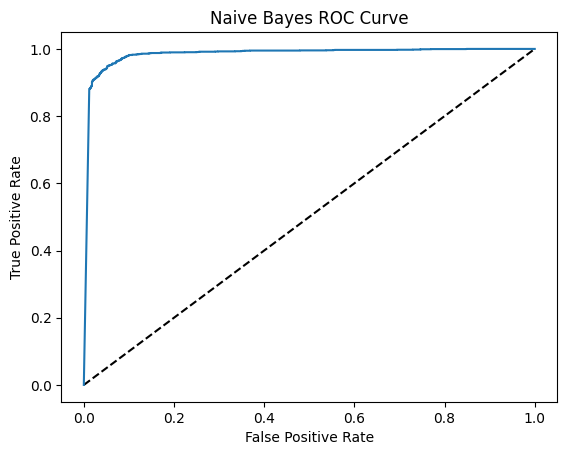

In [36]:
# Naive Bayes Receiver Operating Characteristics Curve
y_proba_nb = model_nb.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba_nb)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes ROC Curve')
plt.show()

In [37]:
# calculate the area under the curve
print('The Area Under the Naive Bayes ROC Curve is:', roc_auc_score(y_test, y_proba_nb))

The Area Under the Naive Bayes ROC Curve is: 0.9840734319896394


In [38]:
# perform k-fold cross-validation
cv_nb = cross_val_score(model_nb, X, y, cv=5)
print("5-fold CV scores:'", cv_nb)
print('This results in a mean accuracy of %.4f' % cv_nb.mean(), 'with standard deviation of %.4f' % cv_nb.std())

5-fold CV scores:' [0.81514941 0.96699097 0.95309243 0.9558568  0.91310393]
This results in a mean accuracy of 0.9208 with standard deviation of 0.0559


In [39]:
# with open('/content/drive/MyDrive/Models/Naive Bayes ' + str(datetime.now()), 'wb') as filepath:
#     pickle.dump(model_nb,filepath)

**2. Support Vector Classification**

In [40]:
from sklearn.svm import SVC

# parameter grid of different hyperparameters to be tuned
param_grid = {'svc__kernel': ('linear', 'poly')}

# create a pipe that applies the StandardScaler() to the data when training/testing
pipe_svc = make_pipeline(StandardScaler(),
                         SVC(probability=True))

# instantiate an instance of GridSearchCV that, when fitting, will cycle through the parameter grid and choose the best classification model
model_svc = GridSearchCV(estimator = pipe_svc, param_grid=param_grid)

# track how long it takes to train the model
start_time = time.time()

# fit the model to our data
model_svc.fit(X_train, y_train)

svc_training_time = time.time() - start_time

# output the training time, best chosen parameters and the model's accuracy on the testing subset
print('Model Training time:', svc_training_time, 'seconds')
print('Best parameters: ', model_svc.best_params_)
print('Accuracy: ', model_svc.score(X_test, y_test))

Model Training time: 41.07869338989258 seconds
Best parameters:  {'svc__kernel': 'poly'}
Accuracy:  0.9801945795691452


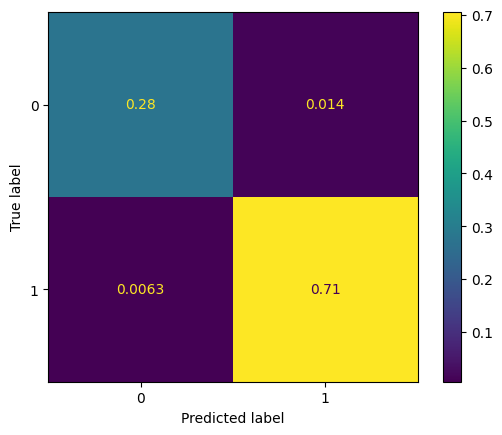

In [41]:
# calculate the model's prediction labels of the test data
y_pred_svc = model_svc.predict(X_test)

# create a normalised confusion matrix comparing predictions to actual y_test values
cm_svc = confusion_matrix(y_test, y_pred_svc, normalize='all')

# plot confusion matrix
ConfusionMatrixDisplay(cm_svc).plot()

In [42]:
# print classification report
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       831
           1       0.98      0.99      0.99      2047

    accuracy                           0.98      2878
   macro avg       0.98      0.97      0.98      2878
weighted avg       0.98      0.98      0.98      2878



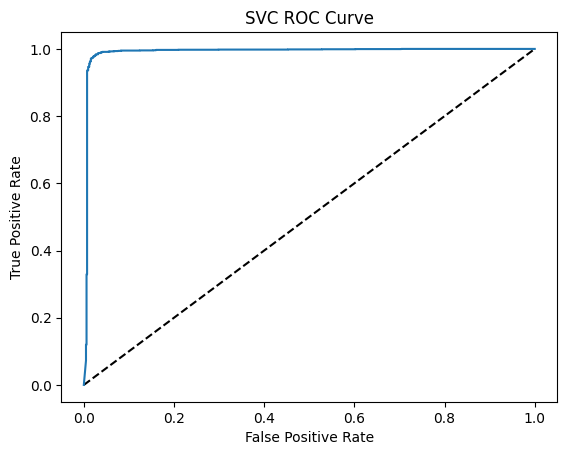

In [43]:
# SVC ROC Curve
y_proba_svc = model_svc.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba_svc)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVC ROC Curve')
plt.show()

In [44]:
# calculate the area under the curve
print('The Area Under the SVC ROC Curve is:', roc_auc_score(y_test, y_proba_svc))

The Area Under the SVC ROC Curve is: 0.9910561492060523


In [45]:
# perform k-fold cross-validation
cv_svc = cross_val_score(model_svc, X, y, cv=5)
print("5-fold CV scores:", cv_svc)
print('This results in a mean accuracy of %.4f' % cv_svc.mean(), 'with standard deviation of %.4f' % cv_svc.std())

5-fold CV scores: [0.96733843 0.98158443 0.98332175 0.98262079 0.97949253]
This results in a mean accuracy of 0.9789 with standard deviation of 0.0059


In [46]:
# with open('/content/drive/MyDrive/Models/Support Vector Classification ' + str(datetime.now()), 'wb') as filepath:
#     pickle.dump(model_svc,filepath)

**3. k-Nearest Neghbours Classifier**

In [47]:
from sklearn.neighbors import KNeighborsClassifier

# parameter grid of different hyperparameters to be tuned
param_grid = [{'kneighborsclassifier__n_neighbors':list(range(2,10))}]

# create a pipe that applies the StandardScaler() to the data when training/testing
pipe_knn = make_pipeline(StandardScaler(),
                        KNeighborsClassifier())

# instantiate an instance of GridSearchCV that, when fitting, will cycle through the parameter grid and choose the best classification model
model_knn = GridSearchCV(estimator=pipe_knn, param_grid=param_grid)

# track how long it takes to train the model
start_time = time.time()

# fit the model to our data
model_knn.fit(X_train, y_train)

knn_training_time = time.time() - start_time

# output the training time, best chosen parameters and the model's accuracy on the testing subset
print('Model Training time:', knn_training_time, 'seconds')
print('Best parameters: ', model_knn.best_params_)
print('Accuracy: ', model_knn.score(X_test, y_test))

Model Training time: 7.680217266082764 seconds
Best parameters:  {'kneighborsclassifier__n_neighbors': 3}
Accuracy:  0.9840166782487839


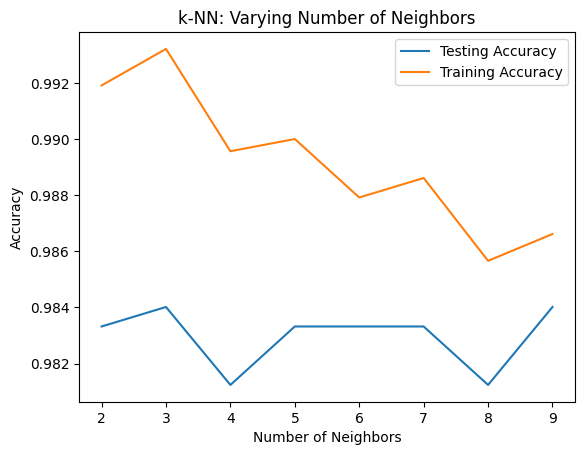

In [48]:
# calculate and plot model accuracy depdning on number of neighbours used
neighbors = np.arange(2,10)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    knn = make_pipeline(StandardScaler(),
                        KNeighborsClassifier(n_neighbors=k))
    knn.fit(X_train, y_train)
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)

plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

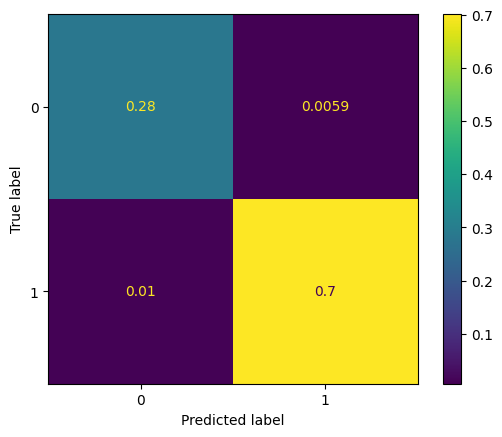

In [49]:
# calculate the model's prediction labels of the test data
y_pred_knn = model_knn.predict(X_test)

# create a normalised confusion matrix comparing predictions to actual y_test values
cm_knn = confusion_matrix(y_test, y_pred_knn, normalize='all')

# plot confusion matrix
ConfusionMatrixDisplay(cm_knn).plot()

In [50]:
# print classification report
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       831
           1       0.99      0.99      0.99      2047

    accuracy                           0.98      2878
   macro avg       0.98      0.98      0.98      2878
weighted avg       0.98      0.98      0.98      2878



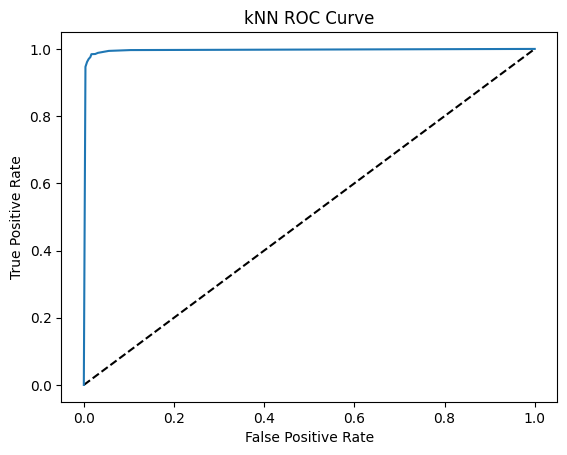

In [51]:
# kNN ROC Curve
y_proba_knn = knn.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba_knn)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('kNN ROC Curve')
plt.show()

In [52]:
# calculate the area under the curve
print('The Area Under the kNN ROC Curve is:', roc_auc_score(y_test, y_proba_knn))

The Area Under the kNN ROC Curve is: 0.9954851601092733


In [53]:
# perform k-fold cross-validation
cv_knn = cross_val_score(model_knn, X, y, cv=5)
print("5-fold CV scores:", cv_knn)
print('This results in a mean accuracy of %.4f' % cv_knn.mean(), 'with standard deviation of %.4f' % cv_knn.std())

5-fold CV scores: [0.94961779 0.98818624 0.98505907 0.99061522 0.98157803]
This results in a mean accuracy of 0.9790 with standard deviation of 0.0150


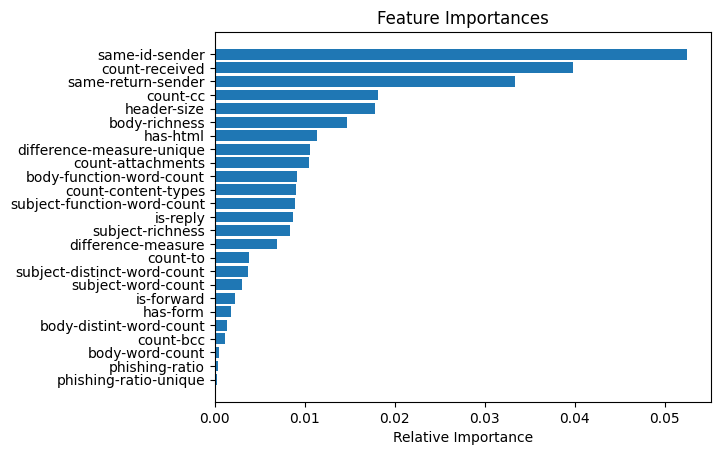

In [54]:
# display the importance of each feature for the kNN Classification
from sklearn.inspection import permutation_importance

results = permutation_importance(model_knn, X, y, scoring='accuracy')

features = X.columns
importances = results.importances_mean
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

In [55]:
# with open('/content/drive/MyDrive/Models/k Nearest Neighbors ' + str(datetime.now()), 'wb') as filepath:
#     pickle.dump(model_knn,filepath)

**4. Decision Tree Classification**

In [56]:
from sklearn.tree import DecisionTreeClassifier

# parameter grid of different hyperparameters to be tuned
param_grid = [{'decisiontreeclassifier__max_depth': list(range(2, 16)),
              'decisiontreeclassifier__criterion': ["gini", "entropy"]}]

# create a pipe that applies the StandardScaler() to the data when training/testing
pipe_dt = make_pipeline(StandardScaler(),
                        DecisionTreeClassifier())

# instantiate an instance of GridSearchCV that, when fitting, will cycle through the parameter grid and choose the best classification model
model_dt = GridSearchCV(estimator = pipe_dt, param_grid=param_grid)

# track how long it takes to train the model
start_time = time.time()

# fit the model to our data
model_dt.fit(X_train, y_train)

dt_training_time = time.time() - start_time

# output the training time, best chosen parameters and the model's accuracy on the testing subset
print('Model Training time:', dt_training_time, 'seconds')
print('Best parameters: ', model_dt.best_params_)
print('Accuracy: ', model_dt.score(X_test, y_test))

Model Training time: 8.967887163162231 seconds
Best parameters:  {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 14}
Accuracy:  0.9885337039610841


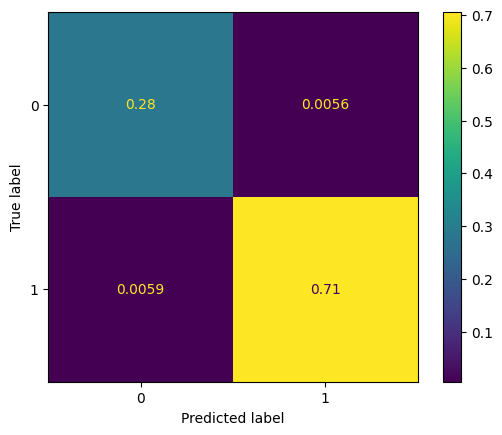

In [57]:
# calculate the model's prediction labels of the test data
y_pred_dt = model_dt.predict(X_test)

# create a normalised confusion matrix comparing predictions to actual y_test values
cm_dt = confusion_matrix(y_test, y_pred_dt, normalize='all')

# plot confusion matrix
ConfusionMatrixDisplay(cm_dt).plot()

In [58]:
# print classification report
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       831
           1       0.99      0.99      0.99      2047

    accuracy                           0.99      2878
   macro avg       0.99      0.99      0.99      2878
weighted avg       0.99      0.99      0.99      2878



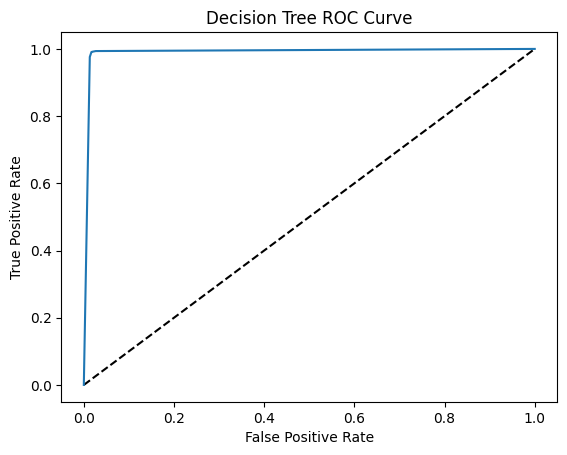

In [59]:
# plot Decision Tree ROC Curve
y_proba_dt = model_dt.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba_dt)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.show()

In [60]:
# calculate the area under the curve
print('The Area Under the DT ROC Curve is:', roc_auc_score(y_test, y_proba_dt))

The Area Under the DT ROC Curve is: 0.9899976896717747


In [61]:
# perform k-fold cross-validation
cv_dt = cross_val_score(model_dt, X, y, cv=5)
print("5-fold CV scores:", cv_svc)
print('This results in a mean accuracy of %.4f' % cv_dt.mean(), 'with standard deviation of %.4f' % cv_dt.std())

5-fold CV scores: [0.96733843 0.98158443 0.98332175 0.98262079 0.97949253]
This results in a mean accuracy of 0.9793 with standard deviation of 0.0114


In [62]:
# with open('/content/drive/MyDrive/Models/Decision Tree ' + str(datetime.now()), 'wb') as filepath:
#     pickle.dump(model_dt,filepath)

**5. Random Forest Classifier**

In [63]:
from sklearn.ensemble import RandomForestClassifier

# parameter grid of different hyperparameters to be tuned
param_grid = [{'randomforestclassifier__max_depth': list(range(2, 16)),
               'randomforestclassifier__criterion': ["gini", "entropy"]}]

# create a pipe that applies the StandardScaler() to the data when training/testing
pipe_rf = make_pipeline(StandardScaler(),
                        RandomForestClassifier())

# instantiate an instance of GridSearchCV that, when fitting, will cycle through the parameter grid and choose the best classification model
model_rf = GridSearchCV(estimator=pipe_rf, param_grid=param_grid)

# track how long it takes to train the model
start_time = time.time()

# fit the model to our data
model_rf.fit(X_train, y_train)

rf_training_time = time.time() - start_time

# output the training time, best chosen parameters and the model's accuracy on the testing subset
print('Model Training time:', rf_training_time, 'seconds')
print('Best parameters: ', model_rf.best_params_)
print('Accuracy: ', model_rf.score(X_test, y_test))

Model Training time: 146.00977563858032 seconds
Best parameters:  {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 14}
Accuracy:  0.9947880472550382


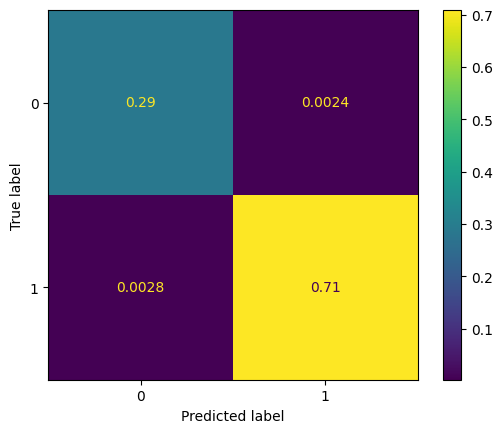

In [64]:
# calculate the model's prediction labels of the test data
y_pred_rf = model_rf.predict(X_test)

# create a normalised confusion matrix comparing predictions to actual y_test values
cm_rf = confusion_matrix(y_test, y_pred_rf, normalize='all')

# plot confusion matrix
ConfusionMatrixDisplay(cm_rf).plot()

In [65]:
# print classification report
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       831
           1       1.00      1.00      1.00      2047

    accuracy                           0.99      2878
   macro avg       0.99      0.99      0.99      2878
weighted avg       0.99      0.99      0.99      2878



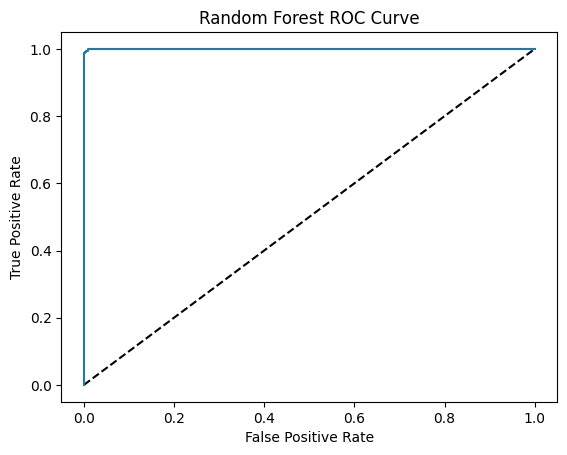

In [66]:
# plot Random Forest ROC Curve
y_proba_rf = model_rf.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba_rf)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.show()

In [67]:
# calculate the area under the curve
print('The Area Under the RF ROC Curve is:', roc_auc_score(y_test, y_proba_rf))

The Area Under the RF ROC Curve is: 0.9997013621530614


In [68]:
# perform k-fold cross-validation
cv_rf = cross_val_score(model_rf, X, y, cv=5)
print("5-fold CV scores:", cv_rf)
print('This results in a mean accuracy of %.4f' % cv_rf.mean(), 'with standard deviation of %.4f' % cv_rf.std())

5-fold CV scores: [0.9819319  0.99478805 0.98922863 0.99617657 0.99443865]
This results in a mean accuracy of 0.9913 with standard deviation of 0.0053


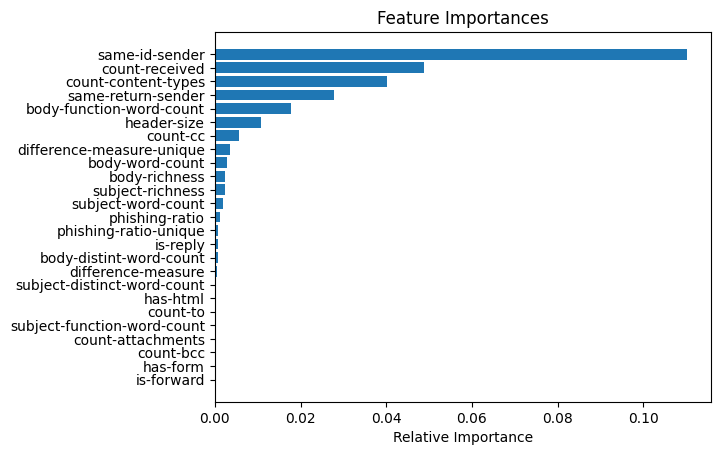

In [69]:
# display the importance of each feature for the kNN Classification
results = permutation_importance(model_rf, X, y, scoring='accuracy')
features = X.columns
importances = results.importances_mean
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

In [70]:
# with open('/content/drive/MyDrive/Models/Random Forest ' + str(datetime.now()), 'wb') as filepath:
#     pickle.dump(model_rf,filepath)

**Further testing on IWSPA No Header Subset**

In [72]:
# make a pandas DataFrame from the features extracted using Extraction.ipynb
extracted_features_no_header = pd.read_csv("https://anti-phish.s3.eu-west-1.amazonaws.com/dataset/extracted/extracted_features_no_header.csv", index_col=0)

# preview the DataFrame
extracted_features_no_header

,phishing,header-size,count-to,count-received,count-cc,count-bcc,same-id-sender,same-return-sender,subject-word-count,subject-distinct-word-count,...,body-word-count,body-distint-word-count,body-richness,body-function-word-count,has-html,has-form,difference-measure,difference-measure-unique,phishing-ratio,phishing-ratio-unique
0,0,49,0,0,0,0,True,True,0,0,...,61,47,0.245968,0,False,False,0,147656,2.576195,23.313646
1,0,49,0,0,0,0,True,True,0,0,...,54,40,0.181818,0,False,False,0,88758,1.815919,14.430322
2,0,49,0,0,0,0,True,True,0,0,...,185,124,0.227552,2,True,False,0,186438,5.259212,41.775256
3,0,49,0,0,0,0,True,True,0,0,...,33,25,0.215686,0,True,False,0,29726,0.427229,3.318847
4,0,49,0,0,0,0,True,True,0,0,...,126,86,0.217993,1,False,False,6,180009,6.045928,35.185558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5716,1,159,1,0,0,0,True,True,3,3,...,1,1,0.166667,0,False,False,0,15657,1.121533,3.600680
5717,1,90,0,0,0,0,True,True,4,4,...,35,31,0.209581,1,False,False,115,135071,5.667323,23.479154
5718,1,49,0,0,0,0,True,True,0,0,...,14,14,0.181818,1,False,False,55,32658,3.616218,9.817490
5719,1,49,0,0,0,0,True,True,0,0,...,81,59,0.184932,3,True,False,1840,155928,22.926205,41.106934


In [73]:
# separate predictor and target variables
X_test_no_header = extracted_features_no_header.drop('phishing', axis = 1)
y_test_no_header = extracted_features_no_header['phishing'].values

In [74]:
print('Naive Bayes generalisable accuracy:', model_nb.score(X_test_no_header, y_test_no_header))
print('kNN generalisable accuracy:', model_knn.score(X_test_no_header, y_test_no_header))
print('SVC generalisable accuracy:', model_svc.score(X_test_no_header, y_test_no_header))
print('Decision Tree generalisable accuracy:', model_dt.score(X_test_no_header, y_test_no_header))
print('Random Forest generalisable accuracy:', model_rf.score(X_test_no_header, y_test_no_header))

Naive Bayes generalisable accuracy: 0.10994581366893899
kNN generalisable accuracy: 0.1882538017829051
SVC generalisable accuracy: 0.8290508652333508
Decision Tree generalisable accuracy: 0.34382101031288237
Random Forest generalisable accuracy: 0.8383149798986191
